# Govermental Actions and Mobility for: 
#### United Kingdom, Italy, United States and Poland

In [270]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""SELECT 
                  g.*, m.transit_stations, m.residential, m.workplace,
                  m.parks, m.retail_recreation, m.grocery_pharmacy
               FROM 
                   government_response AS g LEFT JOIN mobility AS m
               ON 
                   g.date = m.date AND 
                   g.countrycode = m.countrycode AND 
                   COALESCE(g.adm_area_1, '') = COALESCE(m.adm_area_1, '') AND
                   COALESCE(g.adm_area_2, '') = COALESCE(m.adm_area_2, '')
               WHERE 
                   g.date < NOW() AND 
                   g.date > '2020-02-01' AND 
                   g.countrycode IN ('ITA', 'GBR', 'POL', 'USA')
               ORDER BY 
                   g.date
            """)
    
govtrack_mobility_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
conn.close()

In [271]:
govtrack_mobility_data.dropna(subset=['confirmed'], inplace=True)
govtrack_mobility_data.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,confirmed,dead,stringency,stringency_actual,actions,transit_stations,residential,workplace,parks,retail_recreation,grocery_pharmacy
0,GOVTRACK,2020-02-02,United Kingdom,GBR,None,None,None,2,0,14,14,"{'policyActions': [{'notes': '', 'isgeneral': ...",NaN,NaN,NaN,NaN,NaN,NaN
1,GOVTRACK,2020-02-02,Italy,ITA,None,None,None,3,0,28,28,"{'policyActions': [{'notes': '', 'isgeneral': ...",NaN,NaN,NaN,NaN,NaN,NaN
2,GOVTRACK,2020-02-02,Poland,POL,None,None,None,0,0,7,7,"{'policyActions': [{'notes': '', 'isgeneral': ...",NaN,NaN,NaN,NaN,NaN,NaN
3,GOVTRACK,2020-02-02,United States,USA,None,None,None,8,0,9,9,"{'policyActions': [{'notes': '', 'isgeneral': ...",NaN,NaN,NaN,NaN,NaN,NaN
4,GOVTRACK,2020-02-03,United States,USA,None,None,None,11,0,9,9,"{'policyActions': [{'notes': '', 'isgeneral': ...",NaN,NaN,NaN,NaN,NaN,NaN


### Policy extraction

In [272]:
# Extract actions and store first occurence of policy_type_code in dict

colors = cm.rainbow(np.linspace(0, 1, 14) )

def check_policy_actions(row, policy_actions):
    date, confirmed, actions = row  
    
    policy = actions.get('policyActions', {})
    for action in policy:
        policy_code = action.get('policy_type_code')
        policyvalue = action.get('policyvalue', 0)
        
        if policy_code in ['S99', 'S12']: # Skip 'Testing Framework' and 'No data' actions
            continue
        
        policy_code_int = int(policy_code.replace('S',''))
        policy_color = colors[policy_code_int]          
            
        if isinstance(policyvalue, int) and policyvalue > 0:                
            if policy_code not in policy_actions:
                policy_actions[policy_code] = {
                        'first_date': date,
                        'confirmed': confirmed,
                        'policy_type_display': f"{policy_code} - {date}, {action.get('policy_type_display')}",
                        'policy_type_code': policy_code,
                        'color': policy_color
                }
        
    return policy_actions

### Plotting functions

In [273]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import matplotlib.cm as cm
import matplotlib.dates as mdates

def plot(govtrack_data, policy_actions):
    
    categories = ['transit_stations','residential','workplace','parks','retail_recreation','grocery_pharmacy']
    for category in categories:
        category_pretty = category.replace('_', ' ').capitalize()
        
        fig, ax1 = plt.subplots()
        
        # Confirmed cases
        confirmed_color = 'blue'
        ax1.plot(govtrack_data['confirmed'],  linestyle='-', color=confirmed_color, label='Confirmed cases')
        ax1.set_ylabel('Confirmed cases', color=confirmed_color)
        ax1.tick_params(axis='y', labelcolor=confirmed_color)
        
        # Govermental actions
        sorted_lebels = sorted(policy_actions.items(), key=lambda key: key[1].get('first_date'))
        for key, value in sorted_lebels:   
            date = value.get('first_date')
            y_value = value.get('confirmed')
            label = value.get('policy_type_display')
            ax1.scatter(date, y_value, 
                       color=value.get('color'), 
                       marker='s', 
                       alpha=0.7, 
                       s=100, 
                       label=label, 
                       cmap=cm.jet)

        ax1.set_ylabel('Daily confirmed cases')
        ax1.set_title(category_pretty)
        # ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));
        ax1.legend(loc='center left', bbox_to_anchor=(1.4, 0.35), labelspacing=1)
        
        # Dead 
        deaths_color = 'red'
        ax2 = ax1.twinx() 
        ax2.spines["right"].set_position(("axes", 1.16))
        ax2.plot(govtrack_data['dead'],  linestyle='--', color=deaths_color, label='Dead')
        ax2.set_ylabel('Dead', color=deaths_color)
        ax2.tick_params(axis='y', labelcolor=deaths_color)
        ax2.grid(False)
        bottom, top = ax1.get_ylim()
        ax2.set_ylim(bottom, top)
        ax2.legend(loc='center left', bbox_to_anchor=(1.4, 0.9), labelspacing=1)
       
        # Mobility
        categort_color = 'green'
        ax3 = ax1.twinx() 
        ax3.plot(govtrack_data[category],  linestyle='-', color=categort_color, label=category_pretty)
        ax3.set_ylabel(category_pretty + ' [%]', color=categort_color)
        ax3.tick_params(axis='y', labelcolor=categort_color)
        ax3.grid(False)
        ax3.legend(loc='center left', bbox_to_anchor=(1.4, 1), labelspacing=1)
        
        fig.autofmt_xdate()

In [274]:
def plot_country(data, country_code):
    govtrack = data[data['countrycode'] == country_code].reset_index()
    policy_actions = {}
    _ = govtrack[['date','confirmed','actions']].apply(lambda row: check_policy_actions(row, policy_actions), axis=1)
    plot(govtrack.set_index('date'), policy_actions)

### Govermental actions and people mobility for Italy

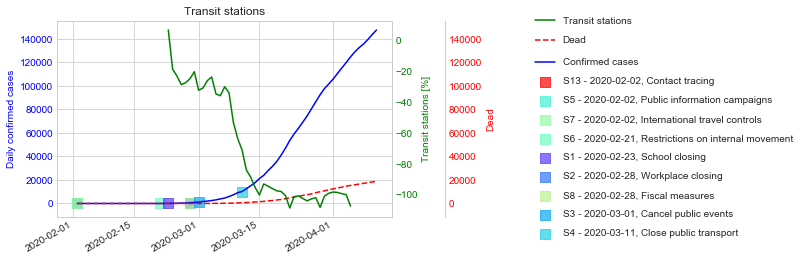

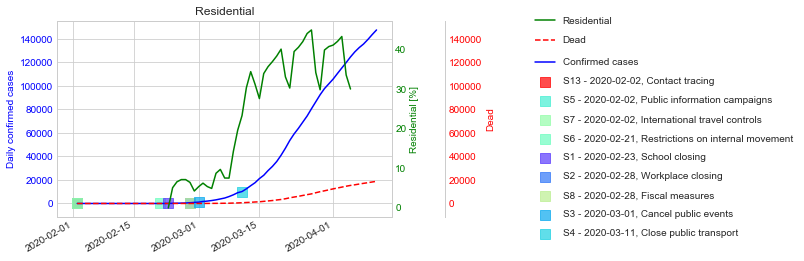

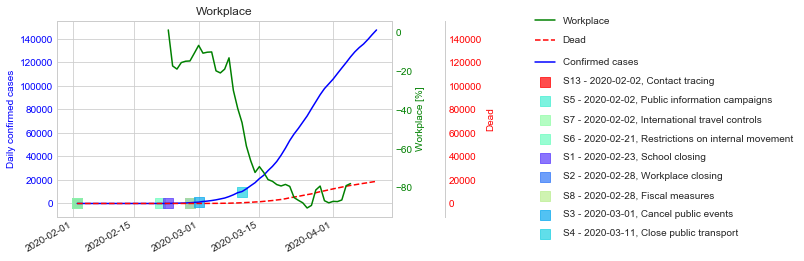

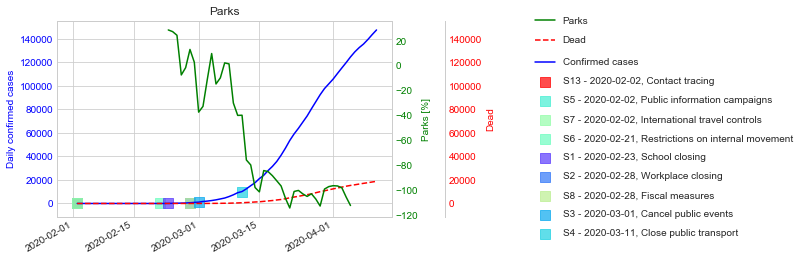

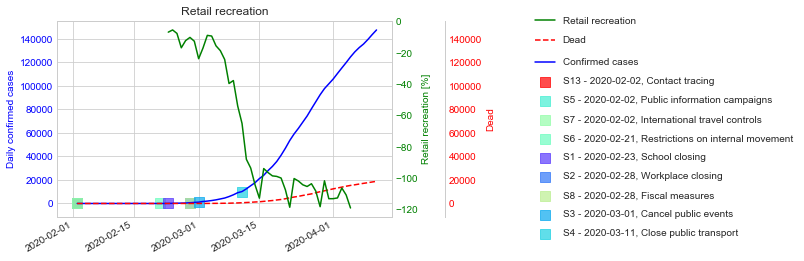

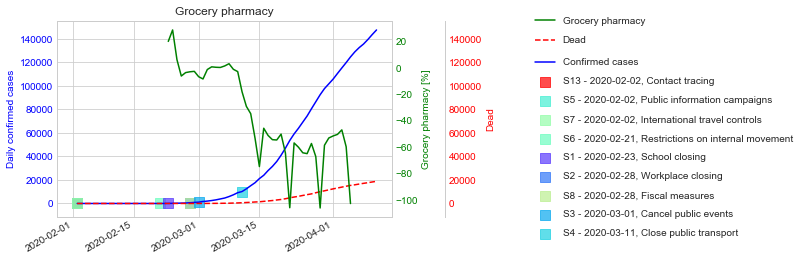

In [275]:
plot_country(govtrack_mobility_data, 'ITA')

### Govermental actions and people mobility for Great Britan

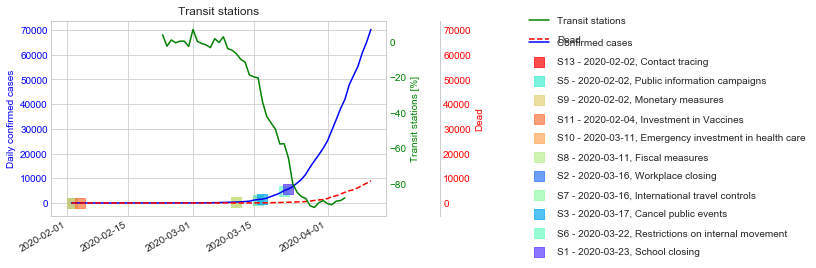

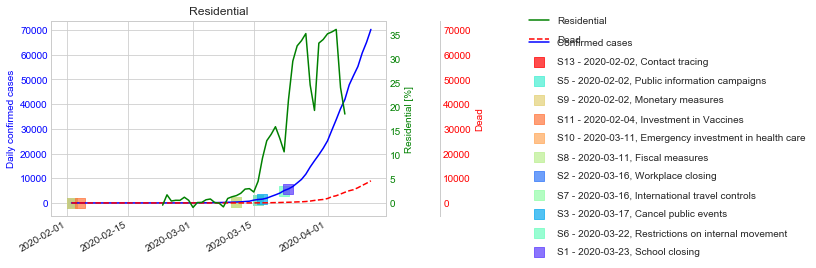

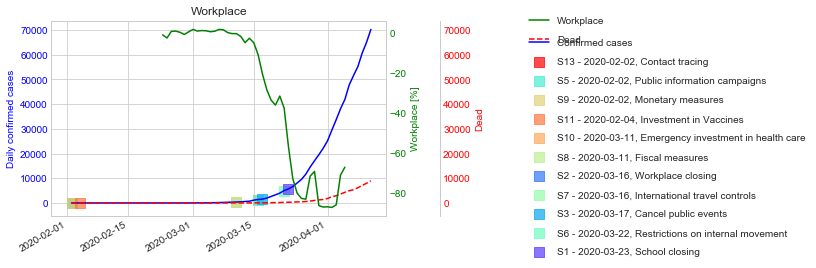

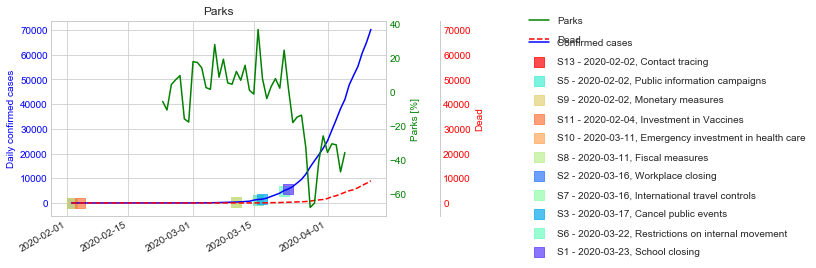

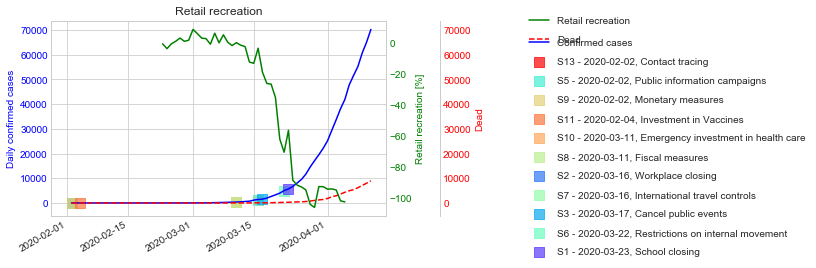

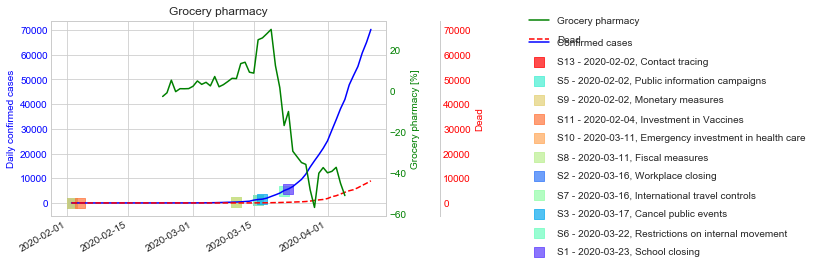

In [276]:
plot_country(govtrack_mobility_data, 'GBR')

### Govermental actions and people mobility for Poland

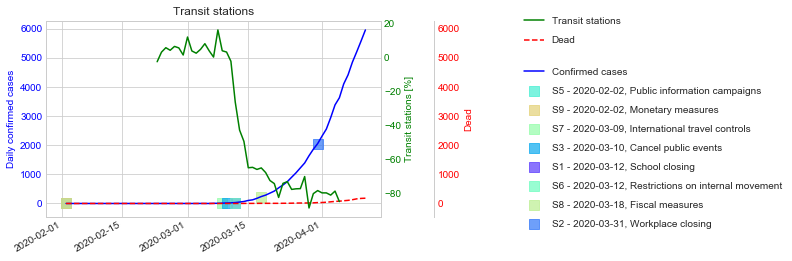

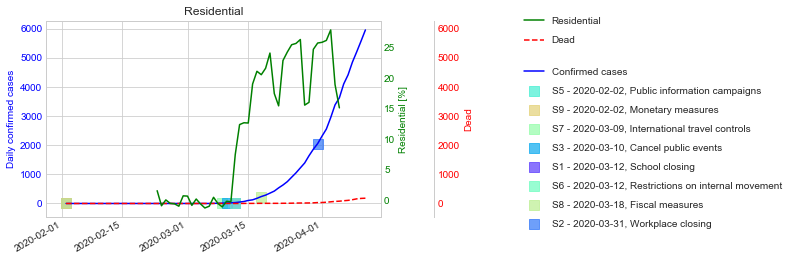

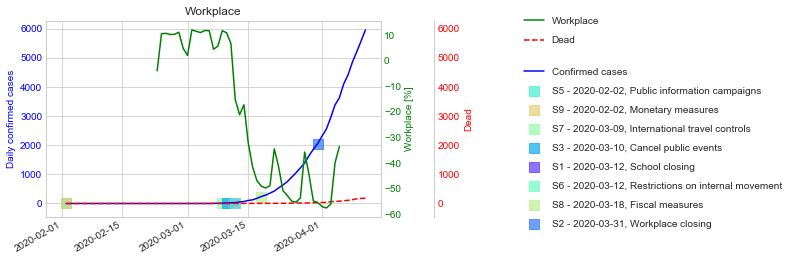

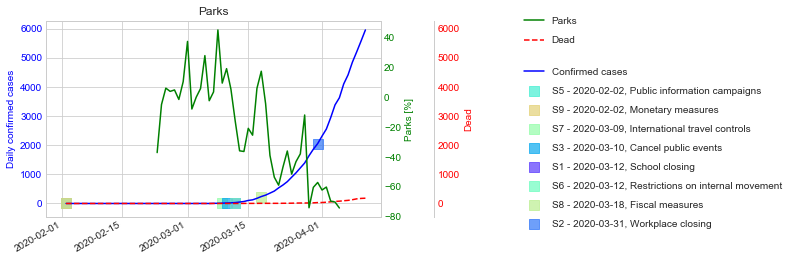

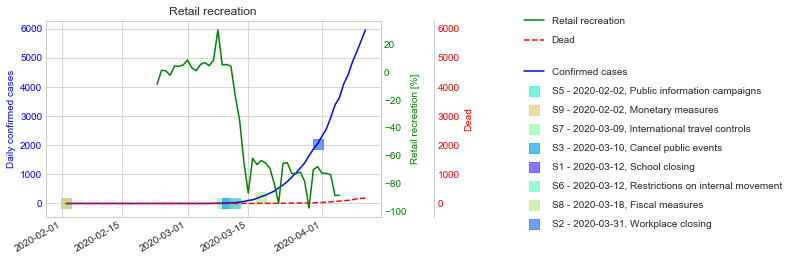

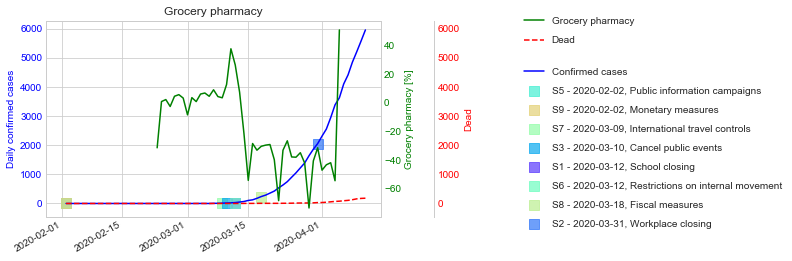

In [277]:
plot_country(govtrack_mobility_data, 'POL')

### Govermental actions and people mobility for United States

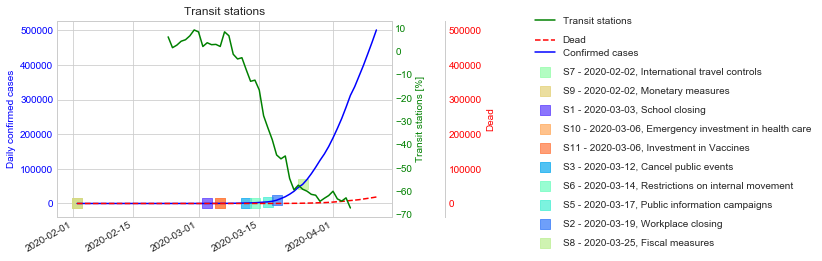

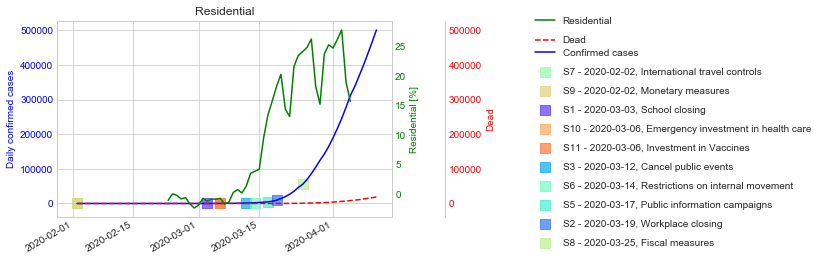

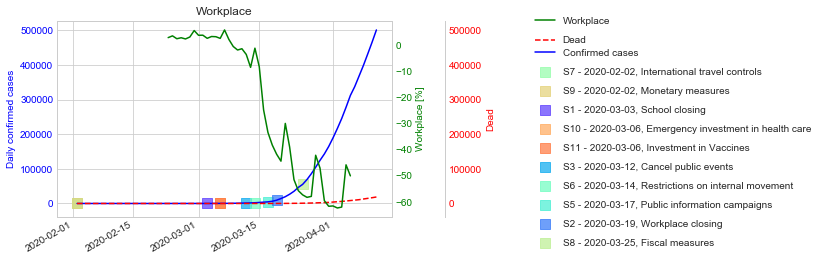

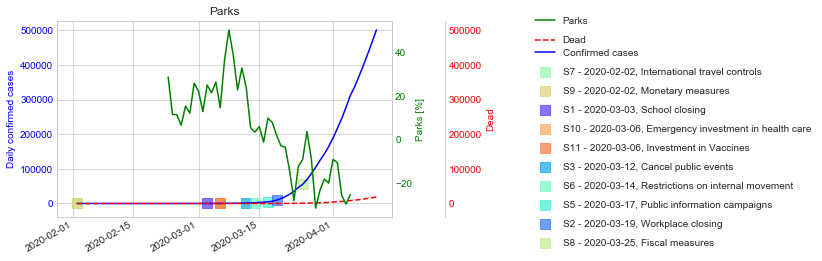

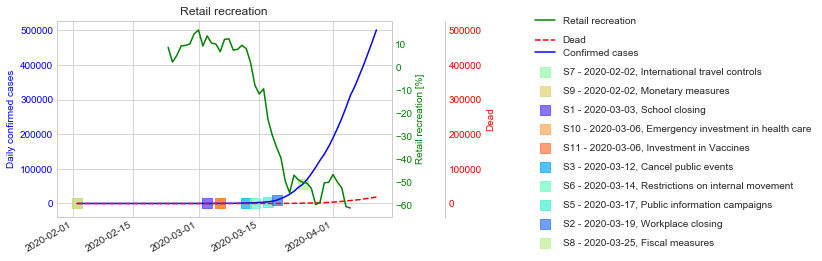

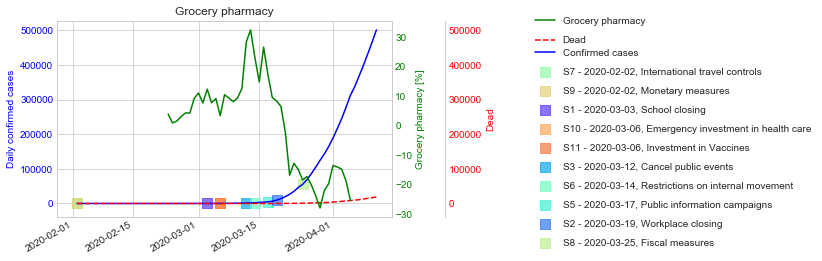

In [278]:
plot_country(govtrack_mobility_data, 'USA')